In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from music21 import chord, note, stream, clef, meter
from data_cleaning import Open
import os
import numpy as np

In [ ]:
# Vocab


In [71]:
all_chords = []


def open_midi_files(dest_directory):
    for root, dirs, files in os.walk(dest_directory):
        # print(dirs)
        for f_i,file in enumerate(files):
            mid_file = os.path.join(root, file)
            midi_data = Open.open_midi(mid_file)
            all_chords.append(f"<song {f_i}>")
            # prog_array = []
            el_array = []
            for i, part in enumerate(midi_data.parts):
                all_chords.append(f"<part {i}>")
                for element in part.recurse():
                    # if isinstance(element, meter.TimeSignature):
                    #     all_chords.append(element.ratioString)
                    if isinstance(element, chord.Chord):
                        all_chords.append("<meta>")
                        all_chords.append(
                            f"chord_quarterlength {element.duration.quarterLength.real}")
                        all_chords.append(f"chord_offset {element.offset}")
                        all_chords.append("<chord_start>")
                        for n in element:
                            all_chords.append(f"note_pitch {n.pitch.midi}")
                            all_chords.append(
                                f"note_velocity {n.volume.velocity}")
                            all_chords.append(
                                f"note_quarterlength {n.duration.quarterLength}")
                            all_chords.append(f"note_offset {n.offset}")
                        all_chords.append("<end>")
                    # elif isinstance(element, chord.Chord):
                    #     # el_array.append([p.midi for p in element.pitches])
                    #     pass
                # if el_array:
                #     prog_array.append(el_array)

            # all_chords.append(el_array)


open_midi_files(os.path.join(os.getcwd(), "sample_rock_set"))

In [105]:
chars = sorted(list(set(all_chords)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
def decode(l):
    return [itos[i] for i in l]
# decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(all_chords), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]


In [ ]:
block_size = 8

x =decode(train_data[:block_size+1].tolist())


In [92]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is tensor([3]) the target: 2
when input is tensor([3, 2]) the target: 42
when input is tensor([ 3,  2, 42]) the target: 14
when input is tensor([ 3,  2, 42, 14]) the target: 0
when input is tensor([ 3,  2, 42, 14,  0]) the target: 116
when input is tensor([  3,   2,  42,  14,   0, 116]) the target: 233
when input is tensor([  3,   2,  42,  14,   0, 116, 233]) the target: 146
when input is tensor([  3,   2,  42,  14,   0, 116, 233, 146]) the target: 78


In [ ]:
torch.manual_seed(1337)
batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

In [130]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):

        # idx and targets are both (B,T) tensor of integers
        logits = self.token_embedding_table(idx) # (B,T,C)
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

m = BigramLanguageModel(vocab_size)
# print(m.token_embedding_table)
# print(xb)
logits, loss = m(xb, yb)
# print(logits.shape)
# print(loss)

# print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=10)[0].tolist()))


['<chord_start>', 'note_velocity 104', 'note_velocity 93', 'chord_offset 3.75', 'note_velocity 47', 'chord_offset 1.0', 'note_pitch 39', 'note_velocity 75', 'chord_quarterlength 1/6', 'chord_offset 2.75', 'note_pitch 57']


In [135]:
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [133]:
losses = []

In [136]:
batch_size =128
for steps in range(10000):
    xb,yb = get_batch('train')
    
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    if steps % 100 == 0:
        losses.append(loss.item())
        print(loss.item())



1.0835044384002686
1.0871989727020264
1.039498209953308
1.1217890977859497
1.0613363981246948
1.0246355533599854
1.0811035633087158
1.1330000162124634
1.1084377765655518
1.0356404781341553
1.1045531034469604
1.083048939704895
1.108473539352417
1.1226918697357178
1.044155240058899
1.0228091478347778
0.9972307682037354
1.0785307884216309
1.0812894105911255
1.1164435148239136
1.0823395252227783
1.0974900722503662
1.118707299232483
1.0590444803237915
1.0895105600357056
1.0354546308517456
1.0477005243301392
1.0519165992736816
1.1016532182693481
1.0118790864944458
1.1069146394729614
1.1006404161453247
1.0808957815170288
1.083325743675232
1.0175695419311523
1.103617548942566
1.0436639785766602
1.0514744520187378
1.0819183588027954
1.0849965810775757
1.1175493001937866
1.057862639427185
1.0873398780822754
1.0776007175445557
1.117800235748291
1.0002721548080444
1.1157904863357544
1.0295450687408447
1.0797821283340454
1.0954296588897705
1.0114946365356445
1.0066699981689453
1.0747356414794922
1.

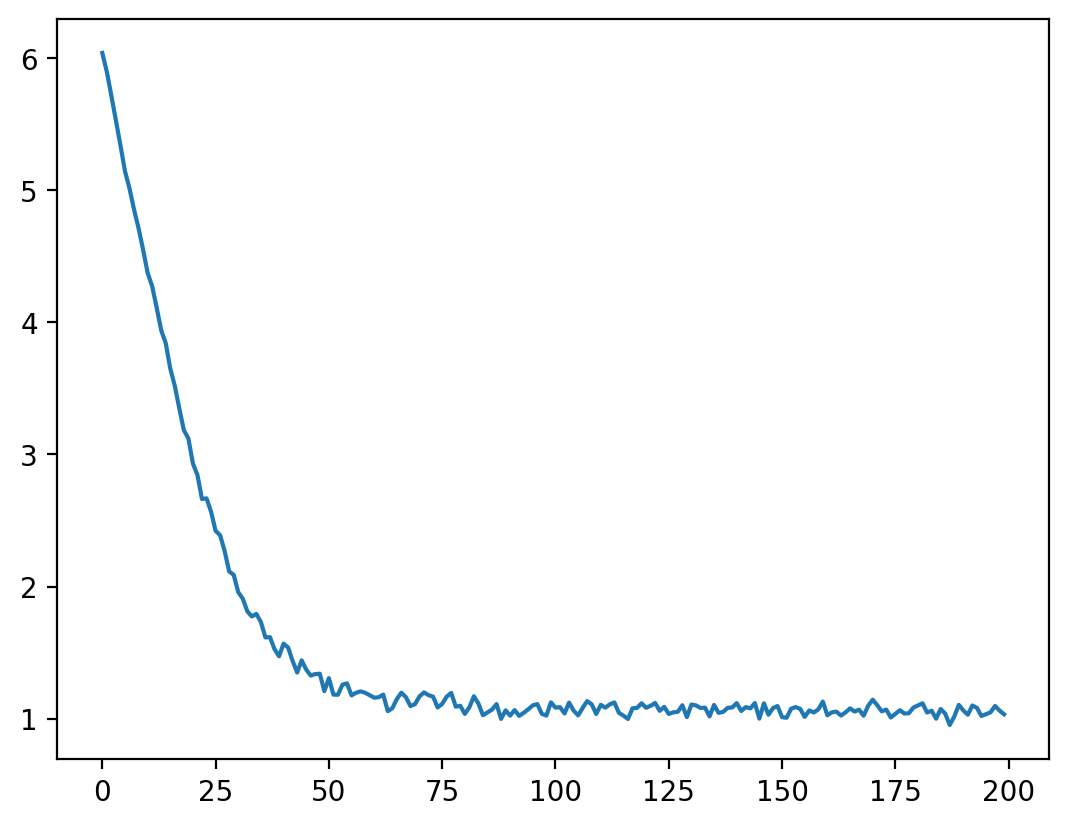

In [137]:
plt.plot(losses)

In [139]:
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=20)[0].tolist()))

['<chord_start>', 'note_pitch 55', 'note_velocity 95', 'note_quarterlength 1.0', 'note_offset 0.0', '<end>', '<meta>', 'chord_quarterlength 0.5', 'chord_offset 1.0', '<chord_start>', 'note_pitch 60', 'note_velocity 95', 'note_quarterlength 1.0', 'note_offset 0.0', '<end>', '<meta>', 'chord_quarterlength 0.25', 'chord_offset 2.75', '<chord_start>', 'note_pitch 57', 'note_velocity 95']
